In [1]:
import numpy as np
import healpy as hp
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from healpy.newvisufunc import projview


In [2]:
import sys
sys.path.insert(1, '/global/homes/h/hrincon/python_tools')

In [3]:
import VoidCatalog as cat

<frozen importlib._bootstrap>:241: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.SpatialMap size changed, may indicate binary incompatibility. Expected 1848 from C header, got 2272 from PyObject


# Read in existing Healpix masks

In [4]:
iron_mask_smoothed_path = '../iron_mask_smoothed.fits'
iron_mask = Table.read(iron_mask_smoothed_path)
nside = hp.get_nside(iron_mask['DONE'])
iron_mask_ngc = Table.read(iron_mask_smoothed_path)['DONE']
iron_mask_sgc = Table.read(iron_mask_smoothed_path)['DONE']
iron_mask_ngc *= (iron_mask['RA'] < 304) * (iron_mask['RA'] > 83)
iron_mask_sgc *= (iron_mask['RA'] > 304) + (iron_mask['RA'] < 83)
iron_mask = hp.ud_grade(iron_mask['DONE'], nside, order_in='NESTED', order_out = 'RING')
iron_mask_ngc = hp.ud_grade(iron_mask_ngc, nside, order_in='NESTED', order_out = 'RING')
iron_mask_sgc = hp.ud_grade(iron_mask_sgc, nside, order_in='NESTED', order_out = 'RING')

In [ ]:
#Read in SDSS galaxies

#zobov_path = '/global/homes/h/hrincon/sdss_compare/V2_REVOLVER-nsa_v1_0_1_Planck2018_zobovoids.dat'
#zone_path = '/global/homes/h/hrincon/sdss_compare/V2_REVOLVER-nsa_v1_0_1_Planck2018_zonevoids.dat'
#hole_path = '/global/homes/h/hrincon/sdss_compare/VoidFinder-nsa_v1_0_1_Planck2018_comoving_holes.txt'
#max_path = '/global/homes/h/hrincon/sdss_compare/VoidFinder-nsa_v1_0_1_Planck2018_comoving_maximal.txt'
nsa_path = '/global/homes/h/hrincon/sdss_compare/nsa_v1_0_1.fits'

nsa = Table.read(nsa_path)
nsa = nsa[nsa["IN_DR7_LSS"].astype(bool)]

ra_boolean = np.logical_and(nsa["RA"] > 110, 
                            nsa["RA"] < 270)

nsa = nsa[ra_boolean]

strip_boolean = np.logical_and.reduce([nsa["RA"] > 250, 
                                       nsa["RA"] < 269, 
                                       nsa["DEC"] > 51, 
                                       nsa["DEC"] < 67])
nsa = nsa[~strip_boolean]
nsa['RA'].name='ra'
nsa['DEC'].name='dec'

In [11]:
sdss_mask = np.zeros(hp.nside2npix(nside // (2**4) ), dtype = bool)
galaxy_pixels = hp.ang2pix(nside // (2**4), nsa['ra'], nsa['dec'], lonlat = True)
sdss_mask[galaxy_pixels] = 1
sdss_mask = hp.ud_grade(sdss_mask, nside)

In [12]:
comp_mask = sdss_mask*iron_mask

# Create smoothed fiducial masks

In [18]:
smoothed_mask = hp.smoothing(iron_mask.astype(float), sigma= 1 * np.pi/180)
iron_mask_smoothed = np.ones_like(iron_mask) * (smoothed_mask > .99)

iron_mask_ngc_smoothed = iron_mask_ngc * iron_mask_smoothed
iron_mask_sgc_smoothed = iron_mask_sgc * iron_mask_smoothed

smoothed_mask = hp.smoothing(comp_mask.astype(float), sigma= 1 * np.pi/180)
comp_mask_smoothed = np.ones_like(comp_mask) * (smoothed_mask > .99)

smoothed_mask = hp.smoothing(sdss_mask.astype(float), sigma= 1 * np.pi/180)
sdss_mask_smoothed = np.ones_like(sdss_mask) * (smoothed_mask > .99)


<Figure size 1280x960 with 0 Axes>

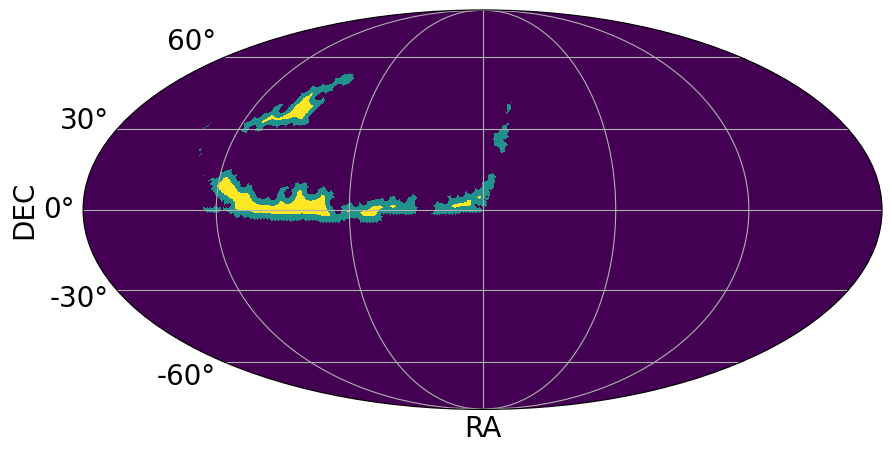

In [9]:
fig = plt.figure(dpi=200)
projview(comp_mask.astype(int) + comp_mask_smoothed.astype(int),rot=125, 
    fig = fig,
    fontsize={'xlabel':20,'ylabel':20,'xtick_label':20,'ytick_label':20},
    graticule=True,
    graticule_labels=True,
    cbar=False,
    #cmap='PuBuGn',
    xlabel="RA",
    ylabel="DEC",
    #custom_xtick_labels=["240°", "180°", "120°", "60°", "0°"],
    custom_xtick_labels=[],
    custom_ytick_labels=["-60°", "-30°", "0°", "30°", "60°"],
    );

# Convert to Cartesian Masks

In [41]:
def healpix2cartesian(healpix_mask, nside, mask_resolution = 12, dec_offset = -90):
    maskY, maskX = np.meshgrid(
        np.arange(mask_resolution * 180)/mask_resolution + dec_offset,
        np.arange(mask_resolution * 360)/mask_resolution
        )
    grid_pixels = hp.ang2pix(nside, maskX, maskY, lonlat = True)
    mask = healpix_mask[grid_pixels]
    return mask, np.sum(healpix_mask) / len(healpix_mask)

iron_mask_whole = healpix2cartesian(iron_mask, nside)
iron_mask_ngc_whole = healpix2cartesian(iron_mask_ngc, nside)
iron_mask_sgc_whole = healpix2cartesian(iron_mask_sgc, nside)
sdss_mask_whole = healpix2cartesian(sdss_mask, nside)
comp_mask_whole = healpix2cartesian(comp_mask, nside)
iron_mask_fid = healpix2cartesian(iron_mask_smoothed, nside)
iron_mask_ngc_fid = healpix2cartesian(iron_mask_ngc_smoothed, nside)
iron_mask_sgc_fid = healpix2cartesian(iron_mask_sgc_smoothed, nside)
sdss_mask_fid = healpix2cartesian(sdss_mask_smoothed, nside)
comp_mask_fid = healpix2cartesian(comp_mask_smoothed, nside)

In [42]:
def plot_mask(mask):
    plt.imshow(np.rot90(mask),interpolation='nearest')
    plt.gca().invert_xaxis()

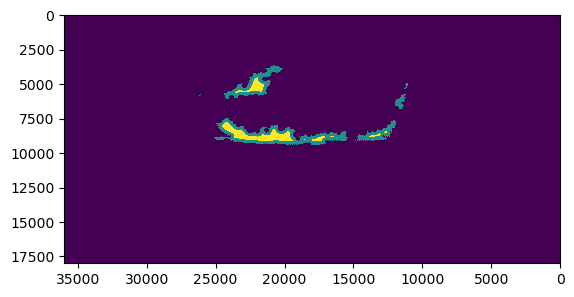

In [43]:
plot_mask(comp_mask_whole[0].astype(int)+comp_mask_fid[0].astype(int))

# Save output

In [ ]:
hdul = fits.HDUList([fits.PrimaryHDU(header=fits.Header())])

# (Make Number) Format floats for headers
def mknum (flt):

    if flt is None:
        return None

    #preserve 3 sig figs for numbers starting with "0."
    if abs(flt) < 1:
        return float(f"{flt:.3g}")
    #otherwise round to two decimal places
    else:
        return float(f"{flt:.2f}")
    
def add_mask (hdul, mask, name):
    hdu = fits.ImageHDU(mask[0].astype(int))
    hdu.name = name
    hdu.header['MSKRES'] = mask[0].shape[0] // 360
    hdu.header['COVSTR'] = mknum(mask[1] * 4 * np.pi) #steradian coverage
    hdu.header['COVDEG'] = mknum( mask[1] * 41252.96) #square degree coverage
    hdul.append(hdu)

add_mask(hdul, iron_mask_whole, 'DESI')
add_mask(hdul, iron_mask_ngc_whole, 'NGC')
add_mask(hdul, iron_mask_sgc_whole, 'SGC')
add_mask(hdul, sdss_mask_whole, 'SDSS')
add_mask(hdul, comp_mask_whole, 'COMP')
add_mask(hdul, iron_mask_fid, 'DESIFID')
add_mask(hdul, iron_mask_ngc_fid, 'NGCFID')
add_mask(hdul, iron_mask_sgc_fid, 'SGCFID')
add_mask(hdul, sdss_mask_fid, 'SDSSFID')
add_mask(hdul, comp_mask_fid, 'COMPFID')

hdul.writeto('masks.fits')


# Mask Analysis

In [1]:
import sys
sys.path.insert(1, '/global/homes/h/hrincon/python_tools')
from VoidSWRadii import sky_fraction
from astropy.cosmology import FlatLambdaCDM
omega_M=0.315
#create cosmology
csm0 = FlatLambdaCDM(H0=100, Om0=omega_M)

<frozen importlib._bootstrap>:241: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.SpatialMap size changed, may indicate binary incompatibility. Expected 1848 from C header, got 2272 from PyObject


In [2]:

def mask_coverage(mask_hdu):
    
    mask, mask_resolution = mask_hdu.data, mask_hdu.header['MSKRES'] 
    dist_limits = [0,667] #value doesn't matter

    tmp_gals = Table(names=['ra','dec'])
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]:
                tmp_gals.add_row([i/mask_resolution, j/mask_resolution - 90])

    tmp_mask = sky_fraction(tmp_gals, csm0, 0.1, min_maximal_radius=10.0, smooth_mask=True)
    #For outres
    return mknum(tmp_mask[0] * 41253) # fraction * num deg^2 in circle



In [34]:
hdul = fits.open('masks.fits')

In [38]:
# note that the mask coverage values are artifically large, because the healpix mask used for it has a low resolution
# We can get around this by using the original high resolution healpix masks (mask.header['COVDEG'])
mask_coverage(hdul['COMPFID'])

474.2

In [36]:
print('NGC:', hdul['NGC'].header['COVDEG'], 'deg^2')
print('SGC:', hdul['SGC'].header['COVDEG'], 'deg^2')
print('DESI:', hdul['DESI'].header['COVDEG'], 'deg^2')
print('NGC Fid.:', hdul['NGCFID'].header['COVDEG'], 'deg^2')
print('SGC Fid.:', hdul['SGCFID'].header['COVDEG'], 'deg^2')
print('DESI Fid.:', hdul['DESIFID'].header['COVDEG'], 'deg^2')
print('SDSS:', hdul['SDSS'].header['COVDEG'], 'deg^2')
print('SDSS DESI Overlap:', hdul['COMP'].header['COVDEG'], 'deg^2')
print('SDSS DESI Overlap Fid.:', hdul['COMPFID'].header['COVDEG'], 'deg^2')

NGC: 2320.45 deg^2
SGC: 385.83 deg^2
DESI: 2706.28 deg^2
NGC Fid.: 879.72 deg^2
SGC Fid.: 94.48 deg^2
DESI Fid.: 974.23 deg^2
SDSS: 7428.59 deg^2
SDSS DESI Overlap: 1307.94 deg^2
SDSS DESI Overlap Fid.: 344.7 deg^2
